### Advice:
Select High-RAM option in Google Colab when running this notebook because loading all COMET models is heavy and thus, running process may crash

In [ ]:
!pip install unbabel-comet

In [3]:
import pickle
import pandas as pd

import comet

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

In [4]:
comet.__version__

'1.1.2'

**Load data for WMT15**

In [82]:
data_type = "wmt15"
preproc_level = "tokenized"

with open("/content/mt.txt") as f:
    hyp_snts = [line[:-1] for line in f] # maybe without strip ?

with open("/content/reference.txt") as f:
    ref_snts = [line[:-1] for line in f]

with open('/content/source.txt', 'rb') as f:
    src_snts = [line[:-1].decode(encoding="utf-8") for line in f]

with open("/content/newstest2015.human.de-en") as f:
    human_scores = [float(line[:-1]) for line in f] 

**Load data for WMT21**

In [ ]:
data_type = "wmt21"
preproc_level = "lowercase_and_tokenized"

with open('/content/all_ref_snts_21.pickle', 'rb') as fp:
    ref_snts = pickle.load(fp)

with open('/content/all_mt_snts_21.pickle', 'rb') as fp:
    hyp_snts = pickle.load(fp)

with open('/content/all_src_snts_21.pickle', 'rb') as fp:
    src_snts = pickle.load(fp)

with open('/content/all_z_mqm_scores.pickle', 'rb') as fp:
    human_scores = pickle.load(fp)

In [83]:
data = []
for i in range(len(src_snts)):
    r = ref_snts[i]
    h = hyp_snts[i]
    s = src_snts[i]
    data_row = {"src": s, "mt": h, "ref": r}
    data.append(data_row)

In [55]:
score_df = pd.DataFrame({'human_scores': human_scores})

In [8]:
model_dict = {1: 'wmt20-comet-da', 2: 'wmt21-comet-mqm', 31: 'wmt20-comet-qe-da', 32: 'wmt21-comet-qe-mqm', 4: 'emnlp20-comet-rank'}

In [ ]:
from comet import download_model, load_from_checkpoint

model_name = model_dict[1]
model_path = download_model(model_name)
model = load_from_checkpoint(model_path)

model_name = model_dict[2]
model_path = download_model(model_name)
model2 = load_from_checkpoint(model_path)

if data_type == 'wmt15':
    model_name = model_dict[31]
else:
    model_name = model_dict[32]    
model_path = download_model(model_name)
model3 = load_from_checkpoint(model_path)

model_name = model_dict[4] 
model_path = download_model("emnlp20-comet-rank") 
model4 = load_from_checkpoint(model_path)

In [84]:
seg_scores, sys_score = model.predict(data, batch_size=8, gpus=1)
score_df[model_dict[1]] = seg_scores

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 63/63 [00:13<00:00,  4.59it/s]


In [85]:
seg_scores2, sys_score2 = model2.predict(data, batch_size=8, gpus=1)
score_df[model_dict[2]] = seg_scores2

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 63/63 [00:13<00:00,  4.60it/s]


In [86]:
if data_type == 'wmt15':
    col_name = model_dict[31]
else:
    col_name = model_dict[32]
seg_scores3, sys_score3 = model3.predict(data, batch_size=8, gpus=1)
score_df[col_name] = seg_scores3

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 63/63 [00:08<00:00,  7.24it/s]


In [87]:
seg_scores4, sys_score4 = model4.predict(data, batch_size=8, gpus=1)
score_df[model_dict[4]] = seg_scores4

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 63/63 [00:04<00:00, 15.07it/s]


### **Analyse obtained scores**

In [81]:
# tokenized, cased data
score_df.corr()

,human_scores,wmt20-comet-da,wmt21-comet-mqm,wmt20-comet-qe-da,emnlp20-comet-rank
human_scores,1.000000,0.796768,0.745741,0.588008,0.444158
wmt20-comet-da,0.796768,1.000000,0.840320,0.649391,0.449089
wmt21-comet-mqm,0.745741,0.840320,1.000000,0.733986,0.507234
wmt20-comet-qe-da,0.588008,0.649391,0.733986,1.000000,0.474708
emnlp20-comet-rank,0.444158,0.449089,0.507234,0.474708,1.000000


---

In [ ]:
score_df[model_dict[1]].plot.hist(figsize=(10,7))

In [ ]:
score_df[model_dict[2]].plot.hist(figsize=(10,7))

In [ ]:
score_df[col_name].plot.hist(figsize=(10,7))

In [ ]:
score_df[model_dict[4]].plot.hist(figsize=(10,7))

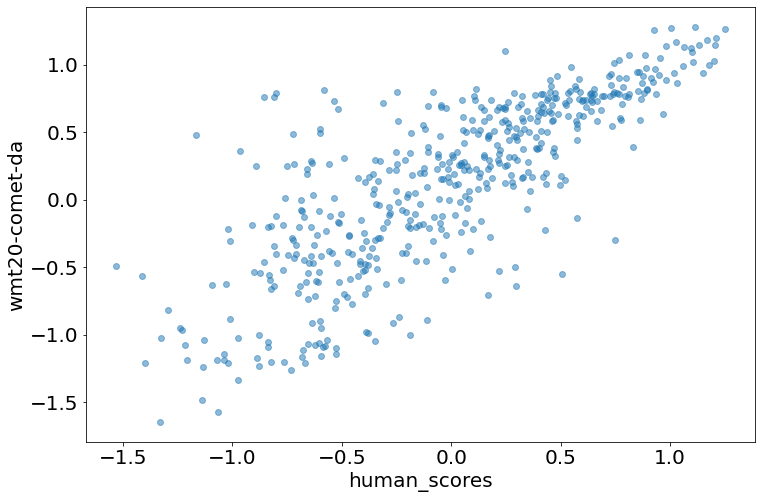

In [43]:
score_df.plot.scatter(x='human_scores', y='wmt20-comet-da', alpha=0.5, figsize=(12,8), s=35, )

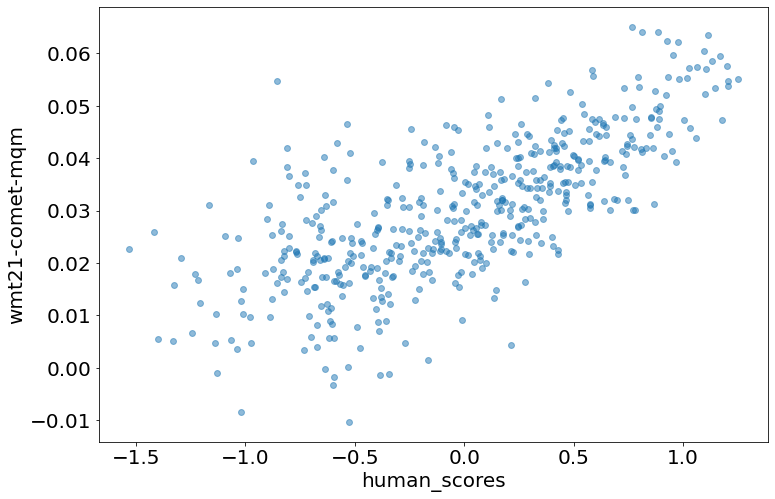

In [52]:
score_df.plot.scatter(x='human_scores', y='wmt21-comet-mqm', alpha=0.5, figsize=(12,8), s=35, )

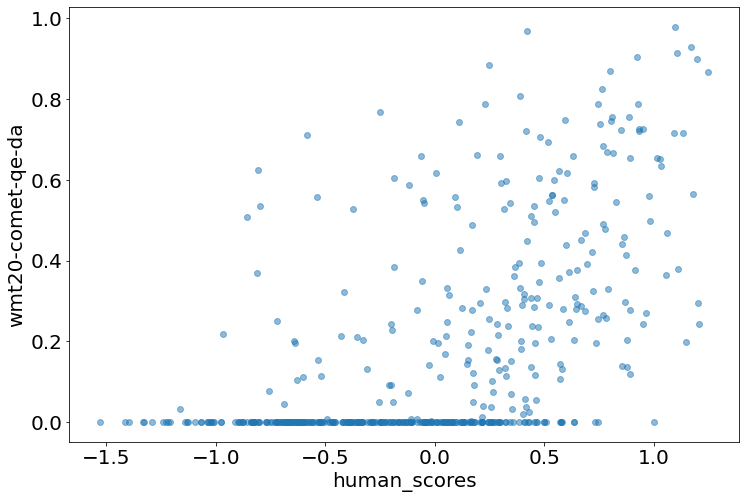

In [44]:
score_df.plot.scatter(x='human_scores', y='wmt20-comet-qe-da', alpha=0.5, figsize=(12,8), s=35)

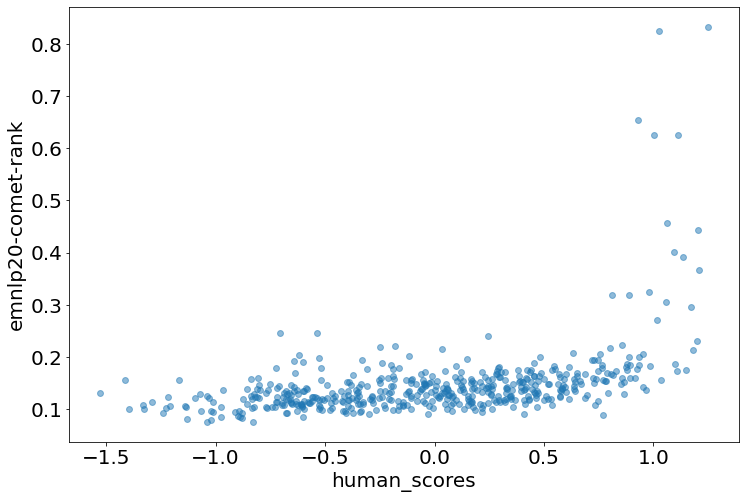

In [45]:
score_df.plot.scatter(x='human_scores', y='emnlp20-comet-rank', alpha=0.5, figsize=(12,8), s=35)

In [39]:
with open(f'comet_scores_df_{data_type}_{preproc_level}.pickle', 'wb') as f:
    pickle.dump(score_df, f, pickle.HIGHEST_PROTOCOL)